### Import Libraries

In [8]:
# Import fungsi time untuk mendapatkan nilai waktu mulai eksekusi
import time
a = time.time()
# Import fungsi matematika
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import fungsi Operating System Directory
import os
from __future__ import print_function, division
from builtins import range, input
# Install and/or Import TF dan Keras & show version
# !pip install tensorflow
# !pip install keras
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version : ', tf.__version__)
print('Keras version : ', keras.__version__)
# Import Pre-trained Model VGG16
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
# Import fungsi untuk Confusion Matrix dan Plot Grafik
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from glob import glob

Tensorflow version :  2.9.1
Keras version :  2.9.0


### Explore Data

In [9]:
# Explore Dataset
from random import shuffle

# Set to Current Working Directory
cwd = os.getcwd()
PATH = os.path.join(cwd, 'OCTQuarter')

# Set to train dir and show number of files
train_path = os.path.join(PATH, 'train')
train_files = glob(train_path + '/*/*.jp*g')
print('Number of training files:', len(train_files))

#Split training set to 50%, 25%, or 10% for faster experimental training


# Set to test dir and show number of files
valid_path = os.path.join(PATH, 'test')
valid_image_files = glob(valid_path + '/*/*.jp*g')
print("Number of Images for validating: ",len(valid_image_files))



Number of training files: 27077
Number of Images for validating:  1000


Found 27077 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.
Found 27077 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Number of classes:  4


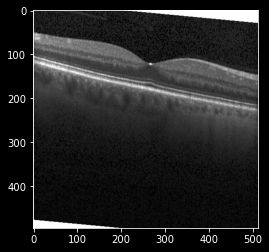

In [10]:
batch_size = 32
# re-size all the images to 100x100
IMAGE_SIZE = [100, 100]

# create generators

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMAGE_SIZE
)

# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

# useful for getting number of classes
folders = glob(train_path + '/*')
print("Number of classes: ",len(folders))

# look at an image for fun
plt.imshow(keras.utils.load_img(np.random.choice(train_files)))

plt.show()

In [11]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

# our layers
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

### Loss and Optimization functions

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [13]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
#for x, y in test_gen:
#    print("min:", x[0].min(), "max:", x[0].max())
#    plt.title(labels[np.argmax(y[0])])
#    plt.imshow(x[0])
#    plt.show()
#    break

Found 1000 images belonging to 4 classes.
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [14]:
# training config:
epochs = 25

# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

C:\Users\LABILK~1\AppData\Local\Temp/ipykernel_17224/2048263441.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/25
846/846 [==============================] - 532s 628ms/step - loss: 3.5074 - accuracy: 0.7062 - val_loss: 3.6139 - val_accuracy: 0.6482
Epoch 2/25
846/846 [==============================] - 528s 624ms/step - loss: 3.0302 - accuracy: 0.7495 - val_loss: 5.6761 - val_accuracy: 0.6290
Epoch 3/25
846/846 [==============================] - 526s 621ms/step - loss: 3.0190 - accuracy: 0.7586 - val_loss: 5.7115 - val_accuracy: 0.6532
Epoch 4/25
846/846 [==============================] - 528s 624ms/step - loss: 2.9935 - accuracy: 0.7652 - val_loss: 5.5069 - val_accuracy: 0.6381
Epoch 5/25
846/846 [==============================] - 526s 621ms/step - loss: 3.0181 - accuracy: 0.7689 - val_loss: 5.2852 - val_accuracy: 0.6704
Epoch 6/25
846/846 [==============================] - 531s 628ms/step - loss: 3.0581 - accuracy: 0.7687 - val_loss: 5.1739 - val_accuracy: 0.6573
Epoch 7/25
846/846 [==============================] - 508s 600ms/step - loss: 3.0314 - accuracy: 0.7742 - val_loss: 4.5312 -

In [15]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_path, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)




Generating confusion matrix 27077
Found 27077 images belonging to 4 classes.
2/2 [==============================] - 1s 527ms/step
50
2/2 [==============================] - 1s 542ms/step
100
2/2 [==============================] - 1s 533ms/step
150
2/2 [==============================] - 1s 522ms/step
200
2/2 [==============================] - 1s 535ms/step
250
2/2 [==============================] - 1s 528ms/step
300
2/2 [==============================] - 1s 532ms/step
350
2/2 [==============================] - 1s 534ms/step
400
1/1 [==============================] - 0s 179ms/step
[[8221  397  528  155]
 [ 306 1848  226  457]
 [ 345  240  992  577]
 [ 341 1296 1345 9803]]
Generating confusion matrix 1000
Found 1000 images belonging to 4 classes.
2/2 [==============================] - 1s 151ms/step
[[227  18   2   3]
 [ 25 198   9  18]
 [ 62  37  92  59]
 [  9  26  26 189]]


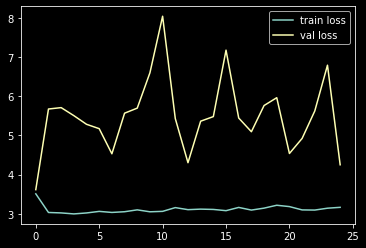

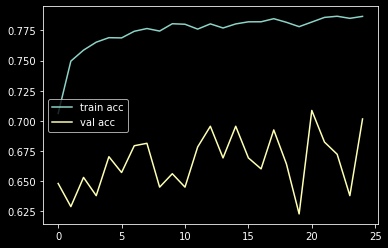

In [16]:
# plot Loss and Accuracies

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


Confusion matrix, without normalization
[[8221  397  528  155]
 [ 306 1848  226  457]
 [ 345  240  992  577]
 [ 341 1296 1345 9803]]


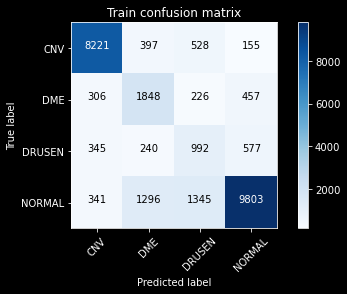

Confusion matrix, without normalization
[[227  18   2   3]
 [ 25 198   9  18]
 [ 62  37  92  59]
 [  9  26  26 189]]


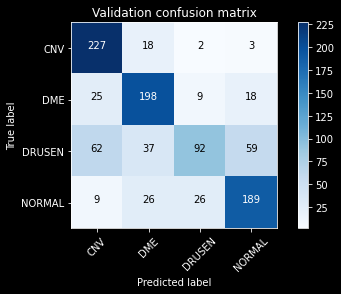

In [17]:
# Plot Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [18]:
b = time.time()
print("time: ", b - a)

time:  13286.036281585693
